# Evaluation


In [56]:
import h5py
import numpy as np
import seaborn as sns
import torch as th
from matplotlib import pyplot as plt
from matplotlib import rcParams

from config import LatentSpectrogramConfig
from tqdne.metric import AmplitudeSpectralDensity, frechet_distance
from tqdne.dataset import Dataset
from tqdne.plot import BinPlot, MovingAverageEnvelopeGrid, AmplitudeSpectralDensityGrid
from tqdne.autoencoder import LightningAutoencoder
from tqdne.edm import LightningEDM, EDM
from tqdne.utils import get_device
import matplotlib.pyplot as plt



In [13]:
config = LatentSpectrogramConfig("workdir", t=4064, latent_channels=4)
config.representation.disable_multiprocessing()

In [25]:
device = get_device()

In [26]:
checkpoint = config.outputdir / f"Autoencoder-32x32x4-LogSpectrogram-c64-b128-gpu4-latent4" / "last.ckpt"
autoencoder = LightningAutoencoder.load_from_checkpoint(checkpoint).to(device)


In [8]:
checkpoint = config.outputdir / f"Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4" / "last.ckpt"
edm = LightningEDM.load_from_checkpoint(checkpoint,  autoencoder=autoencoder)

In [9]:
test = h5py.File("workdir/evaluation/Latent-EDM-32x32x4-LogSpectrogram-c128-b128-gpu4-latent4-split_test.h5", "r")


In [11]:
targets = test["target_waveform"][:10]

In [16]:
signals = config.representation.get_representation(targets)

In [30]:
latent_signals = autoencoder.encode(th.tensor(signals, device=device, dtype=th.float))

In [31]:
latent_signals.shape

torch.Size([10, 4, 32, 32])

In [45]:
sigmas = EDM().sampling_sigmas(num_steps=10)
sigmas = sigmas.cpu().numpy()[::-1]

array([0.0000000e+00, 1.9999996e-03, 2.0435337e-02, 1.1663847e-01,
       4.6997881e-01, 1.5017415e+00, 4.0661230e+00, 9.7232008e+00,
       2.1108667e+01, 4.2415176e+01, 7.9999985e+01], dtype=float32)

In [49]:
latent_signals=latent_signals.detach().cpu().numpy()

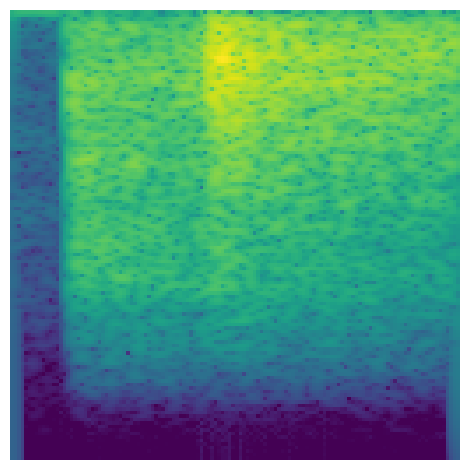

In [82]:
img = plt.imshow(signals[6, 0])
img.set_cmap('viridis')
plt.axis('off')
plt.tight_layout()
plt.savefig("workdir/figures/spectrogram.pdf", transparent="True")

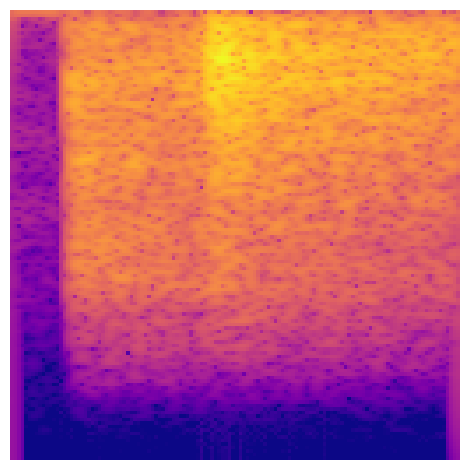

In [81]:
img = plt.imshow(signals[6, 0])
img.set_cmap('plasma')
plt.axis('off')
plt.tight_layout()
plt.savefig("workdir/figures/spectrogram_latent.pdf", transparent="True")

array([ 0.        ,  4.44444444,  8.88888889, 13.33333333, 17.77777778,
       22.22222222, 26.66666667, 31.11111111, 35.55555556, 40.        ])

11


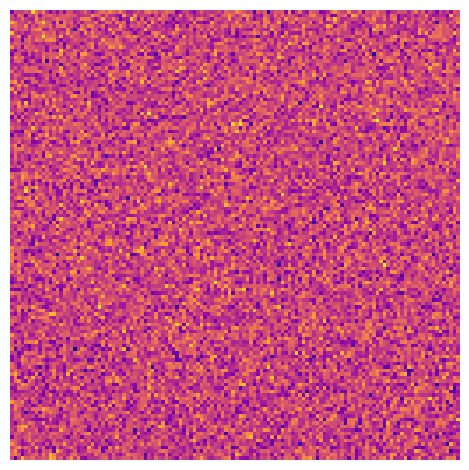

In [ ]:
eps =  np.random.normal(size=signals[6, 0].shape)

def cosine_alpha_schedule(n_timesteps, s=0.008):
    steps = n_timesteps + 2
    x = np.linspace(0, steps, steps)[1:-1]
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
    alphas = np.clip(1.0 - alphas, a_min=0.001, a_max=0.9946)
    return alphas

sigmas = cosine_alpha_schedule(11).tolist() + [10]

for i in range(len(sigmas)):
    img = plt.imshow(signals[6, 0] + eps * sigmas[i])
    img.set_cmap('plasma')
    plt.axis('off')    
    plt.tight_layout()
    plt.savefig(f"workdir/figures/spectrogram_latent-noisy_{i}.png", transparent="True")